## ANLP Assignment 2: Text Generation
### Shuying Piao,  id: a1912828

In [1]:
import pandas as pd

# 1. Reading dataset and initial pre-processing

In [2]:
# Load and process a single dataset (train or test): expand 'ratings', retain other fields, and set 'review_id' as index.
def prepare_dataset(data_path):
    df = pd.read_json(data_path, lines=True)
    df = df.rename(columns={'id': 'review_id'})
    
    ratings_df = df['ratings'].apply(pd.Series)
    extra_columns = [col for col in df.columns if col not in ['text', 'title', 'ratings']]
    
    processed_df = pd.concat([ratings_df, df[extra_columns],df[['text']]], axis=1)
    processed_df = processed_df.set_index('review_id')
    
    return processed_df

In [3]:
train_df= prepare_dataset('hotel_reviews_train.JSON')
test_df= prepare_dataset('hotel_reviews_test.JSON')
train_df.head(3)

,service,cleanliness,overall,value,location,sleep_quality,rooms,check_in_front_desk,business_service_(e_g_internet_access),author,date_stayed,offering_id,num_helpful_votes,date,via_mobile,text
review_id,,,,,,,,,,,,,,,,
140716137,1.0,2.0,1.0,1.0,3.0,2.0,1.0,NaN,NaN,"{'username': 'Kh3RD', 'num_reviews': 1, 'id': ...",September 2012,80138,0,2012-09-19,False,First of all we got there and they didn't have...
114807323,1.0,1.0,1.0,2.0,NaN,1.0,NaN,NaN,NaN,"{'username': 'TheUglyPhotographer', 'num_citie...",June 2011,240151,1,2011-06-27,False,Found Racist graffiti in the room. Request to ...
84805430,4.0,5.0,4.0,3.0,5.0,4.0,4.0,NaN,NaN,"{'username': 'Moonstonemoclips', 'num_cities':...",October 2010,80793,0,2010-10-25,False,Close to Union Square - hotel is a bit of a ma...


In [4]:
# View basic info of the training set: column data types, non-null counts
print("\nTrain Data Info:")
train_df.info()

# View basic info of the test set: column data types, non-null counts
print("\nTest Data Info:")
test_df.info()


Train Data Info:
<class 'pandas.core.frame.DataFrame'>
Index: 24000 entries, 140716137 to 145539000
Data columns (total 16 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   service                                 21550 non-null  float64       
 1   cleanliness                             21545 non-null  float64       
 2   overall                                 24000 non-null  float64       
 3   value                                   21547 non-null  float64       
 4   location                                18983 non-null  float64       
 5   sleep_quality                           14185 non-null  float64       
 6   rooms                                   20000 non-null  float64       
 7   check_in_front_desk                     2909 non-null   float64       
 8   business_service_(e_g_internet_access)  1959 non-null   float64       
 9   author                   

In [5]:
# Define a cleaning function for the target review text
import re

def clean_text_for_generation(text):
    if not isinstance(text, str):
        return ""
    
    text = re.sub(r'[^a-z0-9.,!?\'\";:\-\s]', '', text)  #keep English chars & punctuation
    text = text.lower()  # Convert to lowercase for easier word vector matching
    text = re.sub(r'<.*?>', '', text)  # Remove any HTML tags
    text = re.sub(r'[^\x00-\x7F]+', '', text)   # Remove non-ASCII characters (emoji, non-English characters)
    text = re.sub(r'\s+', ' ', text)  # Normalize whitespace by replacing multiple spaces with a single space
    return text.strip()


train_df['text'] = train_df['text'].apply(clean_text_for_generation)
test_df['text'] = test_df['text'].apply(clean_text_for_generation)

Given that the core task of this assignment is to predict a customer’s review based on the overall rating and aspect-level numerical ratings, the first step in this phase is to expand the ratings field into separate rating dimensions. This facilitates both exploratory data analysis (EDA) and structured model input.

In addition to the ratings, I retained all other metadata fields (such as author, date_stayed, offering_id, etc.), as they may provide meaningful contextual signals for the generation task. Rather than removing records with missing values, I chose to dynamically skip missing fields during input prompt construction. This approach preserves as much useful information as possible while avoiding unnecessary data loss.

To further improve the consistency and quality of the review generation task, I applied text normalization to the text field. The cleaning process includes converting text to lowercase, removing non-ASCII characters, HTML tags, and redundant spaces. This ensures a cleaner and more consistent target output for training the model effectively.

# 2. Exploratory Data Analysis (EDA)

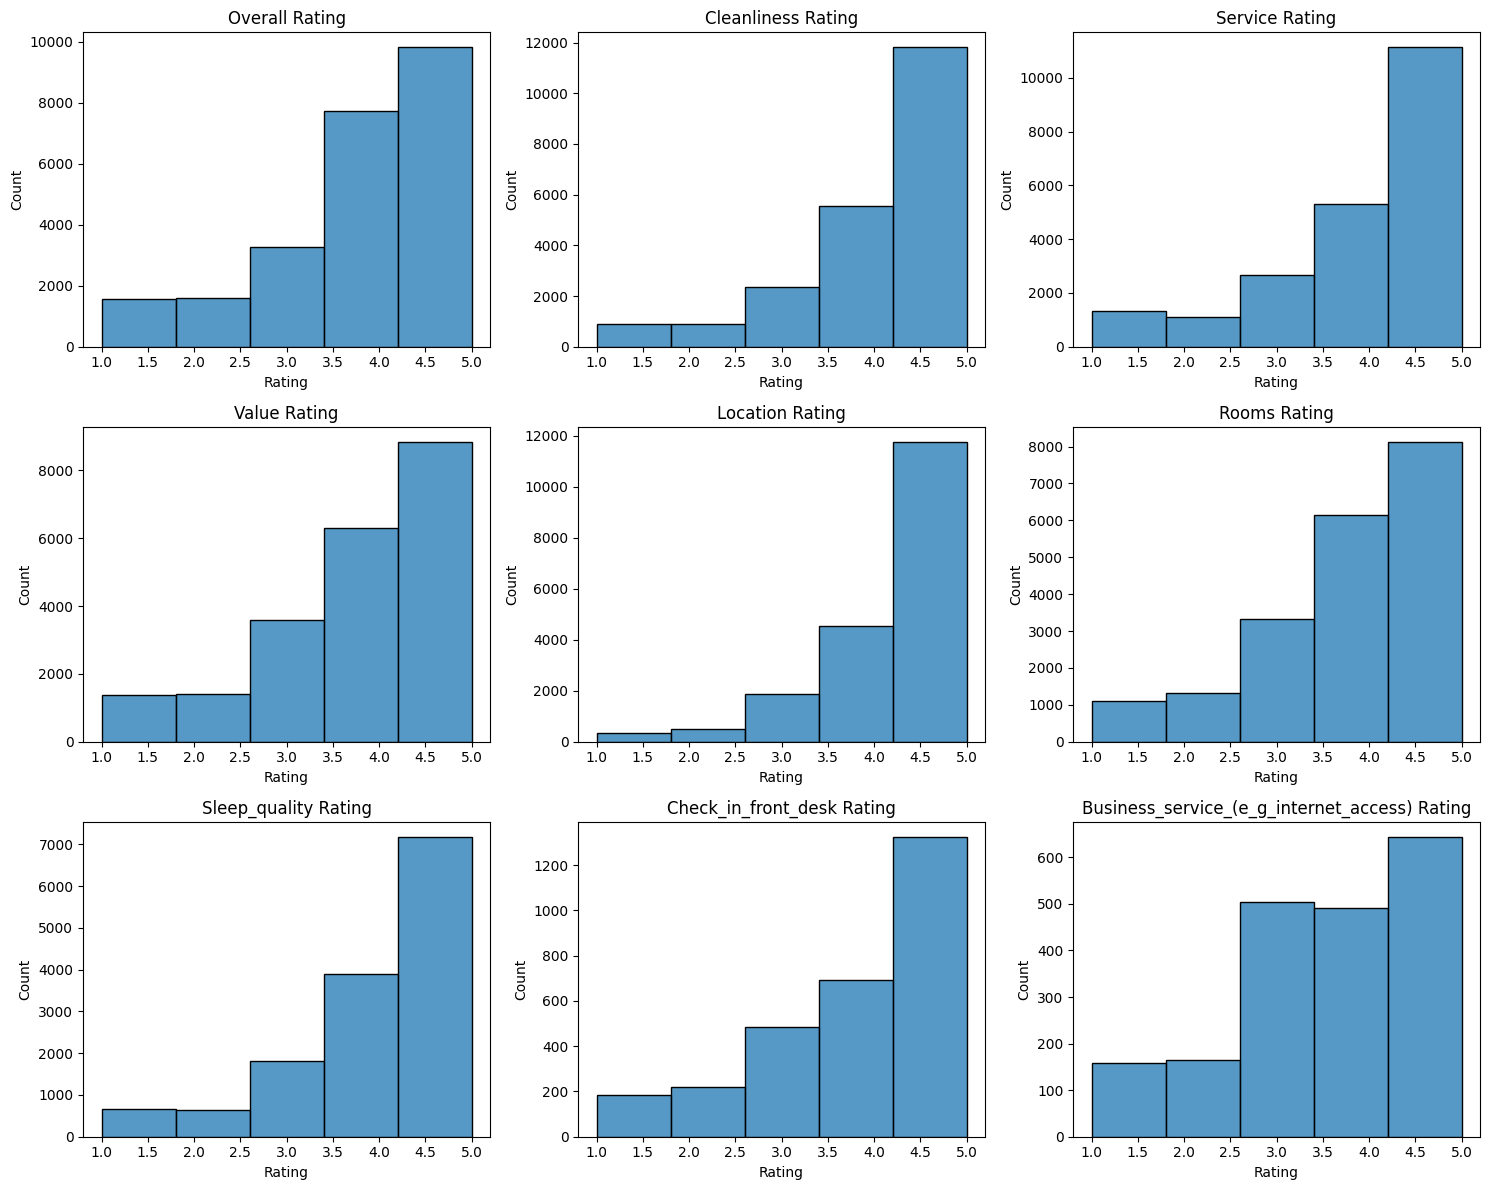

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define rating-related fields
rating_fields = ['overall', 'cleanliness', 'service', 'value', 'location', 'rooms',
                 'sleep_quality', 'check_in_front_desk', 'business_service_(e_g_internet_access)']

# Create a 3x3 subplot grid
fig, axes = plt.subplots(3, 3, figsize=(15, 12)) 

# Loop through rating fields and subplot axes
for ax, field in zip(axes.flatten(), rating_fields):
    if field in train_df.columns:
        sns.histplot(train_df[field].dropna(), bins=5, kde=False, ax=ax)
        ax.set_title(f'{field.capitalize()} Rating')
        ax.set_xlabel('Rating')
        ax.set_ylabel('Count')
    else:
        ax.set_visible(False)  

plt.tight_layout() 
plt.show()

The distribution of overall and aspect-level ratings (e.g., service, cleanliness, value) in the training set reveals the following insights:
1.	Most rating fields exhibit a pronounced right-skewed distribution, with scores concentrated in the $4.0$–$5.0$ range. A rating of $5.0$ is the most common. Certain fields, such as check_in_front_desk and business_service_(e_g_internet_access), have significantly fewer available samples. Meanwhile, attributes like location, sleep_quality, and rooms also show a strong tendency toward high scores, indicating that users generally provided positive feedback on their hotel experiences.

2.	Frequently available rating fields (e.g., overall, cleanliness, service) are more representative and should be prioritized when constructing input prompts for generation models. In contrast, fields with many missing values (e.g., business_service) should be included conditionally during prompt construction to avoid injecting noise or sparsity into the model input.

Token indices sequence length is longer than the specified maximum sequence length for this model (624 > 512). Running this sequence through the model will result in indexing errors


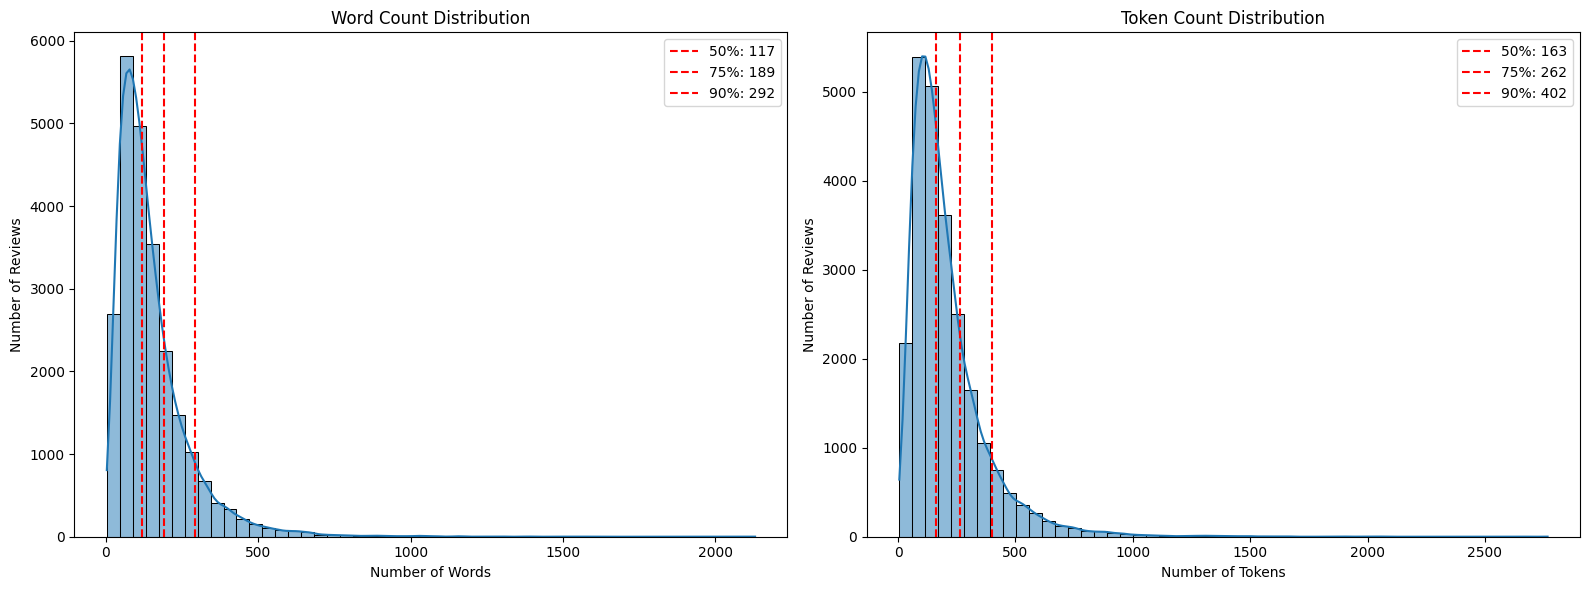

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import T5TokenizerFast

# Calculate number of words per review
train_df['word_count'] = train_df['text'].apply(lambda x: len(str(x).split()) if isinstance(x, str) else 0)

# Load T5 tokenizer
tokenizer = T5TokenizerFast.from_pretrained("t5-small")

# Compute token count
train_df['token_count'] = train_df['text'].apply(
    lambda x: len(tokenizer.encode(str(x), truncation=False)) if isinstance(x, str) and x.strip() else 0
)

# Create 1x2 subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Word count histogram with percentiles
sns.histplot(train_df['word_count'], bins=50, kde=True, ax=axes[0])
axes[0].set_title("Word Count Distribution")
axes[0].set_xlabel("Number of Words")
axes[0].set_ylabel("Number of Reviews")
for p in [0.5, 0.75, 0.9]:
    val = train_df['word_count'].quantile(p)
    axes[0].axvline(val, color='red', linestyle='--', label=f'{int(p*100)}%: {int(val)}')
axes[0].legend()

# Token count histogram with percentiles
sns.histplot(train_df['token_count'], bins=50, kde=True, ax=axes[1])
axes[1].set_title("Token Count Distribution")
axes[1].set_xlabel("Number of Tokens")
axes[1].set_ylabel("Number of Reviews")
for p in [0.5, 0.75, 0.9]:
    val = train_df['token_count'].quantile(p)
    axes[1].axvline(val, color='red', linestyle='--', label=f'{int(p*100)}%: {int(val)}')
axes[1].legend()

plt.tight_layout()
plt.show()

Word and Token Count Distributions:

1.	Word Count Distribution: The median number of words per review is $117$, with $75%$ of reviews containing fewer than $189$ words and 90% fewer than $292$ words. The distribution is heavily right-skewed, indicating that most reviews are relatively short, with only a few exceeding $500$ words.

2.	Token Count Distribution: After tokenization using the T5 tokenizer, the median token count is $163$, with $75%$ of reviews under $262$ tokens and $90%$ under $402$ tokens. Overly long reviews can be safely truncated, while short ones may be padded to ensure consistency in batch processing.

3.	Fairness in Generation Length Settings: To ensure fair comparison between T5-small and GPT-2 in the generation task, both models are constrained to generate at most $128$ tokens. Specifically, T5-small uses max_length=$128$, while GPT-2 uses max_new_tokens=$128$, allowing both to produce comparable-length outputs. Given that 90% of the reviews are shorter than $402$ tokens, this limit captures most meaningful content. Additionally, GPT-2’s max_length during training is capped at $512$ to control the combined length of prompt and target, preventing memory overflow.

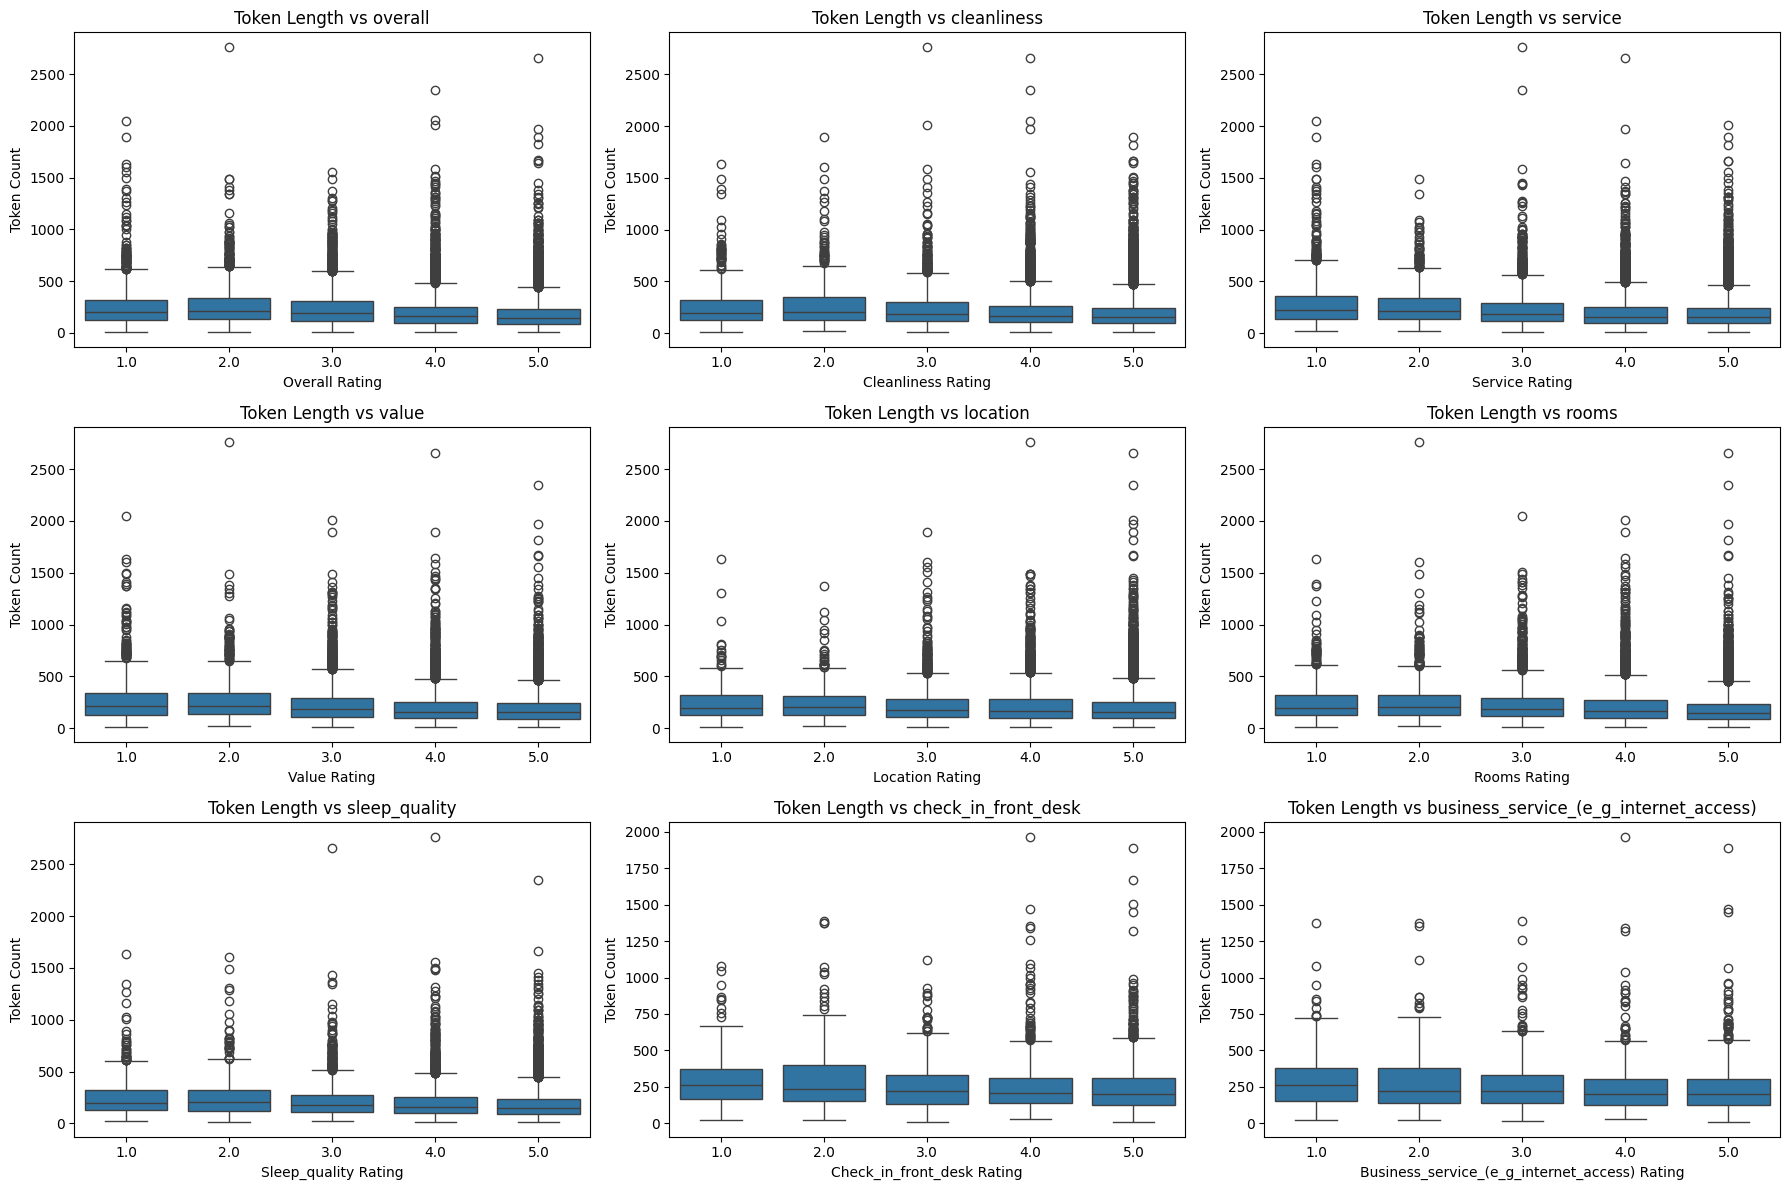

In [9]:
# Show token length per rating score via boxplot
# Create 3x3 subplots
fig, axes = plt.subplots(3, 3, figsize=(18, 12))  

# Loop through each rating field
for ax, field in zip(axes.flatten(), rating_fields):
    if field in train_df.columns:
        sns.boxplot(x=field, y='token_count', data=train_df, ax=ax)
        ax.set_title(f'Token Length vs {field}')
        ax.set_xlabel(f'{field.capitalize()} Rating')
        ax.set_ylabel('Token Count')
    else:
        ax.set_visible(False) 

plt.tight_layout()
plt.show()

Relationship Between Ratings and Review Token Length:

1.	Overall consistency: Token length distributions remain relatively stable across ratings from $1$ to $5$. The interquartile ranges (IQR) are similar, and the medians show minimal variation, suggesting that review length is not strongly influenced by sentiment intensity.

2.	Presence of long-tail reviews: Outliers with significantly longer token counts exist at all rating levels, especially among 4- and 5-star reviews, indicating that highly satisfied users are more likely to write detailed comments.

3.	Slight increase in higher ratings: For certain aspects such as cleanliness, location, and rooms, reviews with a 5-star rating tend to be slightly longer, possibly reflecting the user’s motivation to elaborate on their positive experience.

4.	Rationale for fixed-length generation: While there is some variation in review length across rating levels, we enforce a fixed-length strategy by setting max_length=128 for T5-small and max_new_tokens=128 for GPT-2. This decision ensures consistency across models and evaluation scenarios, minimizing length-induced bias and supporting a fair comparison of generation quality.

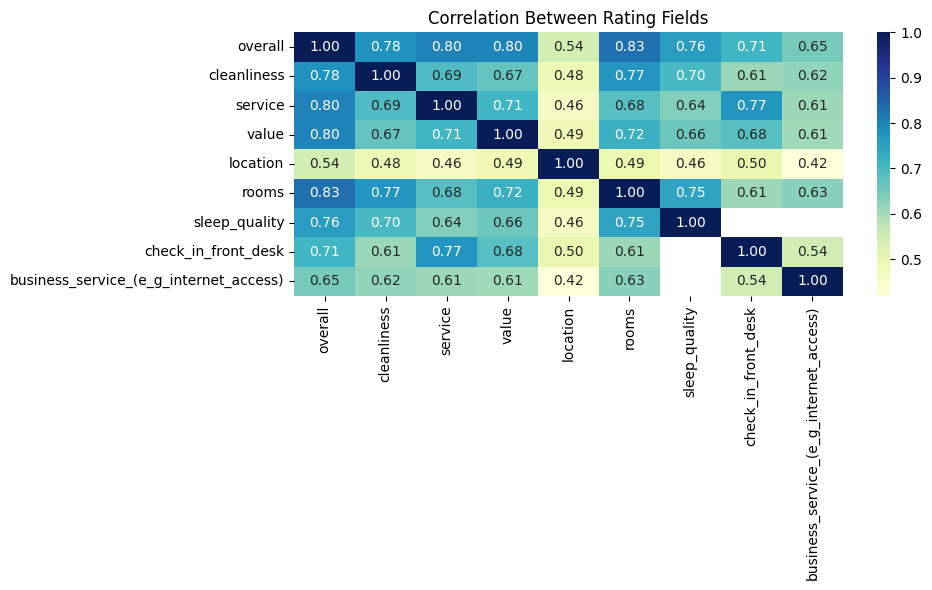

In [10]:
# Compute correlation between rating fields
plt.figure(figsize=(10, 6))
sns.heatmap(train_df[rating_fields].corr(), annot=True, cmap='YlGnBu', fmt=".2f")
plt.title("Correlation Between Rating Fields")
plt.tight_layout()
plt.show()

Correlation Analysis Between Rating Fields:

1.	Generally strong correlations: Most rating fields exhibit correlation coefficients above $0.6$, indicating a consistent rating pattern—users who rate one aspect highly often give high scores to other aspects as well.

2.	Fields strongly correlated with overall: The aspects most strongly correlated with overall are rooms ($0.83$), service ($0.80$), value ($0.80$), and cleanliness ($0.78$). This suggests that these factors contribute more heavily to a user’s overall impression. In contrast, location has a relatively low correlation ($0.54$), indicating it may be evaluated more independently or weigh less in overall satisfaction.

3.	Implications for prompt design and input selection: This correlation analysis offers practical guidance for constructing model input prompts. When not all rating fields can be included due to input length constraints, fields with stronger correlations to overall (e.g., rooms, service, value) should be prioritized to preserve the most influential information. Highly correlated fields may be merged or dimensionally reduced to minimize redundancy. Less correlated fields like location can be optionally excluded if they offer limited value to text generation quality, thereby improving model efficiency and input compactness.

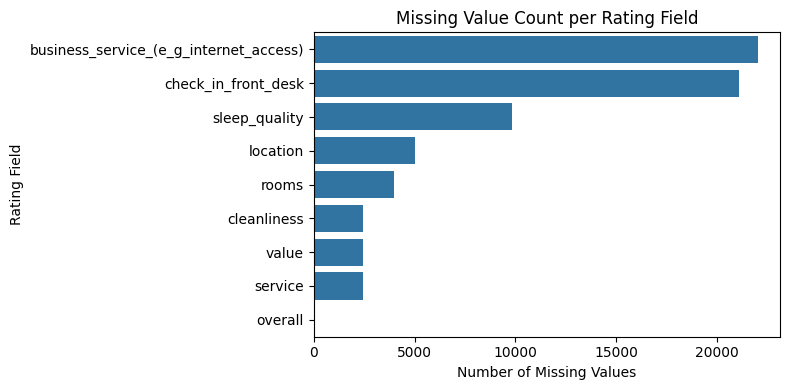

In [11]:
# Count missing values per rating field
missing_counts = train_df[rating_fields].isnull().sum().sort_values(ascending=False)

plt.figure(figsize=(8, 4))
sns.barplot(x=missing_counts.values, y=missing_counts.index)
plt.title("Missing Value Count per Rating Field")
plt.xlabel("Number of Missing Values")
plt.ylabel("Rating Field")
plt.tight_layout()
plt.show()

Missing Value Analysis of Rating Fields:
	
1.	Highly sparse fields: business_service_(e_g_internet_access) and check_in_front_desk show the highest number of missing values—over $22,000$ and $21,000$ respectively—indicating that user ratings for these aspects are extremely rare in the dataset.
	
2.	Moderately missing fields: Fields such as sleep_quality (~$10,000$ missing) and location (~$5,000$ missing) also contain a notable amount of missing data, but they are significantly more complete than the two fields above and may still hold value for modeling.

3.	Relatively complete fields: Fields like overall, service, value, cleanliness, and rooms have fewer than $3,000$ missing entries and are largely complete. These can serve as the core components in prompt construction, providing reliable input features for the generation task.

4.	Implications for prompt construction: When building prompts for the model, it is advisable to dynamically include only the available rating fields while skipping the missing ones. This maximizes the use of each sample’s valid information and prevents discarding data unnecessarily. Highly sparse fields (e.g., business_service, check_in_front_desk) should be designed as optional segments in the prompt template to avoid occupying space when data is unavailable. Prioritizing complete fields improves training data coverage and supports model stability during learning.

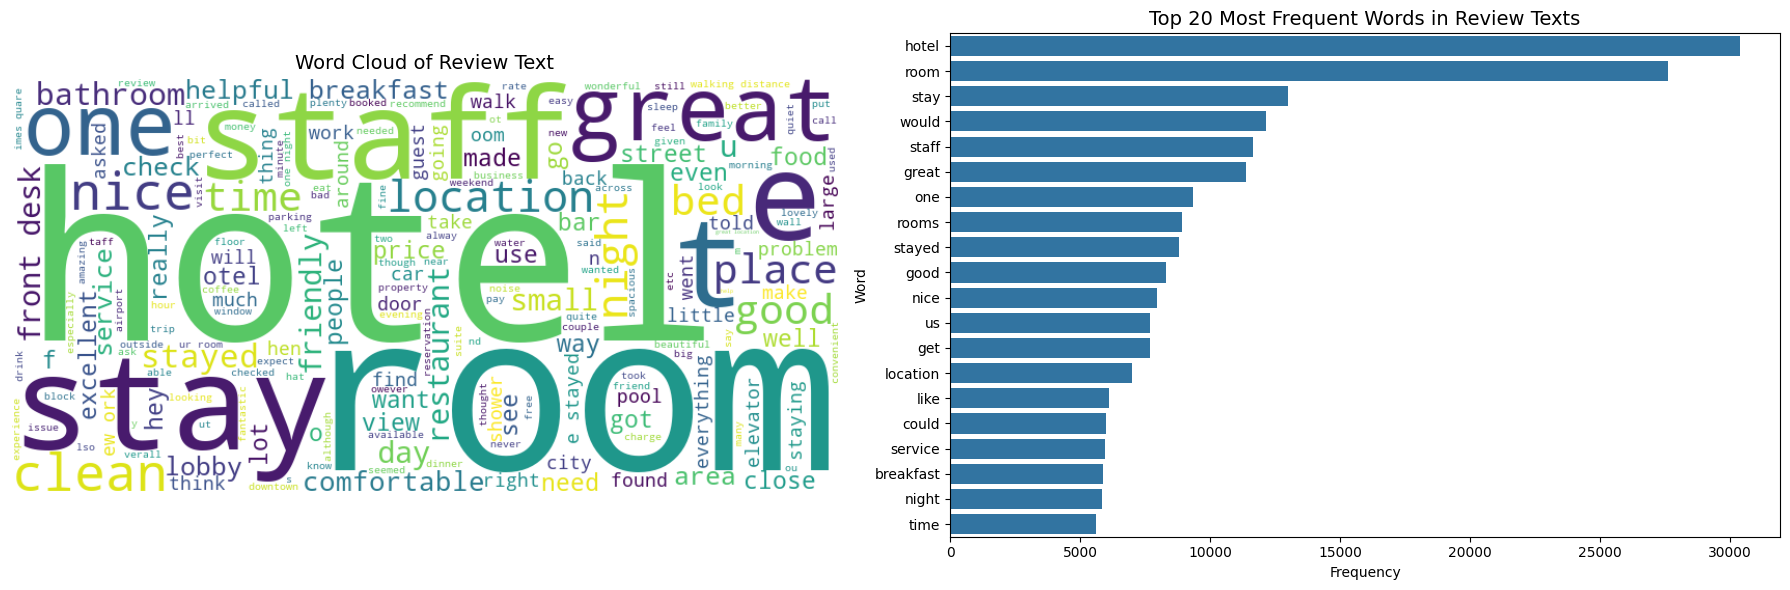

In [30]:
from wordcloud import WordCloud
from collections import Counter
import nltk
from nltk.corpus import stopwords
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Download English stopwords from NLTK
# nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Concatenate all reviews into a single string
all_text = " ".join(train_df['text'].dropna().tolist())

# Tokenize and convert to lowercase
word_list = all_text.lower().split()

# Remove stopwords and keep only alphabetic words
filtered_words = [word for word in word_list if word not in stop_words and word.isalpha() and len(word) > 1]

# Count word frequencies
word_freq = Counter(filtered_words)

# Convert the top 20 frequent words to a DataFrame
freq_df = pd.DataFrame(word_freq.most_common(20), columns=['Word', 'Frequency'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

# Create a 1-row 2-column visualization layout
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot the word cloud
axes[0].imshow(wordcloud, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title("Word Cloud of Review Text", fontsize=14)

# Plot the word frequency bar chart
sns.barplot(x='Frequency', y='Word', data=freq_df, ax=axes[1])
axes[1].set_title('Top 20 Most Frequent Words in Review Texts', fontsize=14)
axes[1].set_xlabel('Frequency')
axes[1].set_ylabel('Word')

plt.tight_layout()
plt.show()

Word Cloud and Frequency Statistics:

1.	Distribution of frequent words: As shown in the word cloud and bar chart, the most commonly used words in reviews include hotel, room, stay, staff, great, one, nice, clean, and location. These keywords represent the main aspects users care about—overall experience, room quality, service, and location.

2.	Dominance of positive sentiment: Words such as great, nice, good, and friendly appear frequently. Combined with the earlier observation of a right-skewed rating distribution, this confirms that the dataset is generally positive in tone.

3.	Presence of both content and structural words: Words like staff and room are content nouns, while stay, would, and get serve grammatical or structural roles. This indicates that the review style is conversational, subjective, and expressive.

4.	Implications for prompt design: These high-frequency words highlight common linguistic patterns in user reviews and can inspire more natural and contextually relevant prompt templates to guide text generation.

# 3. Selection and training Machine Learning models

## 3.1 Model-Oriented Data Preprocessing

In [13]:
from sklearn.model_selection import train_test_split

# Split the original training dataset into train and development datasets
train_set, dev_set = train_test_split(train_df, test_size=0.2, random_state=42, shuffle=True)

#Print the size of each split to verify
print(f"Train set size: {len(train_set)}") 
print(f"Dev set size: {len(dev_set)}")


Train set size: 19200
Dev set size: 4800


In [14]:
#Data Preprocessing: prompt
def build_prompt(row, model_type):

    # Fields to include
    prompt_fields = [
        "service", "cleanliness", "overall", "value", "location", "sleep_quality",
        "rooms", "check_in_front_desk", "business_service_(e_g_internet_access)",
        "date_stayed", "offering_id", "num_helpful_votes", "date", "via_mobile"
    ]

    # 1. Handle ratings
    ratings = row.get("ratings", {})
    rating_strs = [f"{k}={v}" for k, v in ratings.items() if pd.notna(v)]

    # 2. Handle additional flat fields
    aux_strs = []
    for field in prompt_fields:
        if field in row and pd.notna(row[field]):
            aux_strs.append(f"{field}={row[field]}")

    # 3. Handle author.location if available
    if isinstance(row.get("author"), dict):
        location = row["author"].get("location", None)
        if pd.notna(location) and location != "":
            aux_strs.append(f"author_location={location}")

    # 4. Combine
    ratings_part = ", ".join(rating_strs)
    aux_part = ", ".join(aux_strs)

    # 5. Format prompt
    if model_type == "t5":
        prompt = f"generate review given ratings: {ratings_part}."
        if aux_part:
            prompt += f" additional info: {aux_part}."
        prompt += " text:"
    elif model_type == "gpt2":
        prompt = f"A customer gave these ratings: {ratings_part}."
        if aux_part:
            prompt += f" Context: {aux_part}."
        prompt += " Here's a possible review they might have written: "
    else:
        raise ValueError("Unsupported model_type. Choose 't5' or 'gpt2'.")

    return prompt

In [15]:
example_prompt = build_prompt(train_set.iloc[0].to_dict(), model_type="t5")
print(example_prompt)

generate review given ratings: . additional info: service=2.0, cleanliness=1.0, overall=1.0, value=2.0, location=2.0, date_stayed=December 2012, offering_id=114578, num_helpful_votes=0, date=2012-12-15 00:00:00, via_mobile=False, author_location=SOUTH LYON. text:


In [16]:
# Generate prompt for train_set
train_set["input_prompt"] = train_set.apply(lambda row: build_prompt(row.to_dict(), model_type="t5"), axis=1)

# Generate prompt for dev_set
dev_set["input_prompt"] = dev_set.apply(lambda row: build_prompt(row.to_dict(), model_type="t5"), axis=1)

In [17]:
for i in range(3):
    print(f"[Prompt {i+1}]:")
    print(train_set['input_prompt'].iloc[i])
    print("-" * 100)

[Prompt 1]:
generate review given ratings: . additional info: service=2.0, cleanliness=1.0, overall=1.0, value=2.0, location=2.0, date_stayed=December 2012, offering_id=114578, num_helpful_votes=0, date=2012-12-15 00:00:00, via_mobile=False, author_location=SOUTH LYON. text:
----------------------------------------------------------------------------------------------------
[Prompt 2]:
generate review given ratings: . additional info: service=5.0, cleanliness=5.0, overall=5.0, value=5.0, location=4.0, sleep_quality=5.0, rooms=5.0, date_stayed=October 2011, offering_id=286988, num_helpful_votes=0, date=2011-10-13 00:00:00, via_mobile=False, author_location=Atlanta, Georgia. text:
----------------------------------------------------------------------------------------------------
[Prompt 3]:
generate review given ratings: . additional info: service=5.0, cleanliness=5.0, overall=4.0, value=5.0, location=4.0, sleep_quality=5.0, rooms=5.0, date_stayed=November 2012, offering_id=123036, num_

In [18]:
# !pip install sentencepiece

In [ ]:
 from transformers import T5Tokenizer
# 1. T5-small: token

# Load T5 tokenizer
t5_tokenizer = T5Tokenizer.from_pretrained("t5-small")

# Tokenization function
def tokenize_t5(sample):
    input_encoding = t5_tokenizer(
        sample['input_prompt'],
        padding="max_length",        # pad to max length
        truncation=True,             # truncate if too long
        max_length=512,
        return_tensors="pt"          # return PyTorch tensors
    )

    target_encoding = t5_tokenizer(
        sample['text'],
        padding="max_length",
        truncation=True,
        max_length=128,
        return_tensors="pt"
    )

    return {
        "input_ids": input_encoding.input_ids.squeeze(),         # remove batch dim
        "attention_mask": input_encoding.attention_mask.squeeze(),
        "labels": target_encoding.input_ids.squeeze()
    }

# Example
sample = train_set.iloc[0]
encoded_t5 = tokenize_t5(sample)
print(encoded_t5)
# 2. GPT-2:token


#https://www.kaggle.com/code/vinitkp/text-to-text-transfer-transformer
#https://huggingface.co/docs/transformers/model_doc/t5#transformers.T5Tokenizer

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


{'input_ids': tensor([ 3806,  1132,   787,  9712,    10,     3,     5,  1151,  2845,    10,
          313,  2423, 24273,     6, 31582,  2423, 12734,     6,  1879,  2423,
        12734,     6,   701,  2423, 24273,     6,  1128,  2423, 24273,     6,
          833,   834,  8070,  2423, 29835,  1673,     6,  1772,   834,    23,
           26,  2423, 18959,  3436, 11864,     3,  5525,   834, 15061,  1329,
          834,  1621,  1422,  2423,   632,     6,   833,  2423, 12172,  5947,
        10106,     3,  1206,    10,   632, 25713,     6,  1009,   834, 14814,
         2423,   371,  5405,    15,     6,  2291,   834, 14836,  2423,   134,
         9744,   566,     3,  5121,  4170,     5,  1499,    10,     1,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0, 

In [ ]:
from transformers import GPT2Tokenizer

# Load GPT-2 tokenizer
gpt2_tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token  

# Tokenization function
def tokenize_gpt2(sample):
    full_input = sample['input_prompt'] + " " + sample['text']

    encoding = gpt2_tokenizer(
        full_input,
        padding="max_length",         
        truncation=True,             
        max_length=512,
        return_tensors="pt"
    )

    return {
        "input_ids": encoding.input_ids.squeeze(),
        "attention_mask": encoding.attention_mask.squeeze()
    }

# Example
sample = train_set.iloc[0]
encoded_gpt2 = tokenize_gpt2(sample)
print(encoded_gpt2)

#https://huggingface.co/docs/transformers/model_doc/gpt2#transformers.GPT2Tokenizer


{'input_ids': tensor([ 8612,   378,  2423,  1813, 10109,    25,   764,  3224,  7508,    25,
         2139,    28,    17,    13,    15,    11,  3424, 26061,    28,    16,
           13,    15,    11,  4045,    28,    16,    13,    15,    11,  1988,
           28,    17,    13,    15,    11,  4067,    28,    17,    13,    15,
           11,  3128,    62,   301, 16548,    28, 20588,  2321,    11,  6011,
           62,   312,    28,  1157,  2231,  3695,    11,   997,    62, 16794,
          913,    62, 29307,    28,    15,    11,  3128,    28,  6999,    12,
         1065,    12,  1314,  3571,    25,   405,    25,   405,    11,  2884,
           62, 24896,    28, 25101,    11,  1772,    62, 24886,    28,    50,
         2606,  4221,   406,    56,  1340,    13,  2420,    25,   339,  2119,
          373,  4457,  3024,   290,  5894,    11,   262, 12370, 11949,   373,
          845,   795,  8071,  6587,  3371,   514,   475,   612,  2492,   470,
          881,   339,   714,   466,  1201,   340, 

## 3.2 Define evaluation metric functions

In [21]:
# 1. General Evaluation Metrics

In [22]:
# 2. Word-Level Semantic Similarity

In [23]:
# 3. Sentence-Level Semantic Similarity

In [31]:
# 4. Combined Semantic Evaluation

# 4. Selection and training Machine Learning models

# Appendix

## Two contrasting versions of the build_prompt function template

In [32]:
# Basic prompt
def build_prompt_basic(row):
    rating_fields = ["overall", "cleanliness", "service", "value", "location", "rooms", 
                     "sleep_quality", "check_in_front_desk", "business_service_(e_g_internet_access)"]
    parts = []
    for field in rating_fields:
        if pd.notna(row.get(field)):
            parts.append(f"{field}={row[field]}")

    prompt = "generate review given ratings: " + ", ".join(parts) + ". text:"
    return prompt

In [33]:
#  Natural language style prompt
def build_prompt_natural(row):
    parts = []

    def add(field, label):
        val = row.get(field)
        if pd.notna(val):
            parts.append(f"{label} rating was {val}")

    add("overall", "overall")
    add("cleanliness", "cleanliness")
    add("service", "staff/service")
    add("value", "value for money")
    add("location", "location")
    add("rooms", "room quality")
    add("sleep_quality", "sleep quality")
    add("check_in_front_desk", "check-in experience")
    add("business_service_(e_g_internet_access)", "internet/business service")

    if parts:
        ratings_str = "; ".join(parts)
        return f"The guest gave the following feedback: {ratings_str}. Based on this, generate a possible review:"
    else:
        return "The guest left no rating. Generate a general review:"

In [34]:
train_df["prompt_basic"] = train_df.apply(build_prompt_basic, axis=1)
train_df["prompt_natural"] = train_df.apply(build_prompt_natural, axis=1)